In [1]:
#
# This MaterialsAutomated example shows how to overlay simulated Laue spots on 
# experimental data in an automated fashion. 
#
# It utilizes an existing open-source Laue diffraction analysis toolkit, LaueTools:
#   https://gitlab.esrf.fr/micha/lauetools
#
# If the goal is to analyze a single or small number of data sets in isolation, 
# and manually, the LaueTools GUI can be used directly.
# 

#
# This cell defines the main function that does most of the work: calcLaue
# It takes as input:
#   detdimxy: a 2-tuple of the number of pixels along the x and y axis of the detector
#   latticeparam: a list containing the unit cell size and shape [a,b,c,alpha,beta,gamma]
#                 (in units of Angstrom and degrees)
#   Extinc: extinction conditions, i.e. which spots should be removed due to glide planes,
#           centering operators, etc. See full details in ApplyExtinctionrules in
#           https://gitlab.esrf.fr/micha/lauetools/-/blob/master/LaueTools/CrystalParameters.py
#   UB: Orientation matrix for the crystal grain. This tool assumes that the incident
#       beam is parallel to the x-axis.
#   dd: Shortest Sample-Detector distance in mm (default: 30 mm)
#   betgam: 2-tuple defining the beta and gamma angles for the detector; see
#           https://gitlab.esrf.fr/micha/lauetools/-/blob/master/LaueTools/LaueGeometry.py
#           for details; the most common need is to adjust gamma to reflect a rotation in the
#           plane of the detector.
#   Ecut: Minimum and maximum energies of allowed reflections in KeV [assumes x-rays].
#         If data is neutron or electrons, give the range of X-ray energies that correspond
#         to the wavelength range of the neutron or electron source.
#   pixsize: Size of each pixel (including dead area) in mm (default: 0.15 mm)
#   trans: If True, transmission mode, if False, reflection mode (default: False)
#
# The basic algorithm is to compute the position on the detector for every possible hkl
# in the range (-30,30) for each h,k,l component that is not extinct by symmetry, and then
# only keep those that fall on the detector and fit the given energy window.
#
# Returns a 5-tuple of h,k,l,x,y (indices and detector pixel positions)
#
import numpy as np
from LaueTools.lauecore import calcSpots_fromHKLlist
import LaueTools.CrystalParameters as CP
def calcLaue(detdimxy,latticeparam,Extinc=None,UB=np.identity(3),dd=30,betgam=(0.0,0.0),Ecut=(5.0,15.0),pixsize=0.15,trans=False):
    B0=CP.calc_B_RR(latticeparam)
    HKLs=[]
    for i in range(-30,30):
        for j in range(-30,30):
            for k in range(-30,30):
                HKLs.append([i,j,k])
    HKLs=np.array(HKLs)
    HKLs=CP.ApplyExtinctionrules(HKLs,Extinc)
    dictCCD = {}
    dictCCD["dim"] = detdimxy # pixels x pixels
    dictCCD["CCDparam"] = [dd,detdimxy[0]/2,detdimxy[1]/2,*betgam]
    dictCCD["pixelsize"] = pixsize # pixel size
    if trans:
        dictCCD["kf_direction"] = 'X>0' # transmission
    else:
        dictCCD["kf_direction"] = 'X<0' # back-reflection
    spots = calcSpots_fromHKLlist(UB, B0, HKLs, dictCCD)
    (H, K, L, Qx, Qy, Qz, X, Y, twthe, chi, Energy) = spots
    subset = []
    for i in range(0,len(X)):
        if X[i] >= 0 and X[i] < detdimxy[0] and Y[i] >= 0 and Y[i] < detdimxy[1] and Energy[i]>=Ecut[0] and Energy[i]<=Ecut[1]:
            subset.append([H[i],K[i],L[i],X[i],Y[i]])
    HKLss = np.array(subset,dtype=np.int64)[:,0:3].T
    XYss = np.array(subset)[:,3:5].T
    return (HKLss[0],HKLss[1],HKLss[2],XYss[0],XYss[1])

LaueToolsProjectFolder /home/idies/miniconda3/envs/py37/lib/python3.7/site-packages/LaueTools
you are using python 3
Cython compiled module for fast computation of Laue spots is not installed!


In [2]:
#
# Given an image and a set of laue spots, returns a new image
# with the predicted spots overlaid on the image.
#
from PIL import ImageDraw
def overlayLaue(iminp,spots,size=1,color="red"):
    im = iminp.copy()
    spots = np.array(spots).T
    draw = ImageDraw.Draw(im)
    for i in range(0,len(spots)):
        draw.ellipse((spots[i][3]-size,spots[i][4]-size,spots[i][3]+size,spots[i][4]+size),fill=color,outline=color)
    return im


/home/idies/miniconda3/envs/py37/lib/python3.7/site-packages/LaueTools/LaueGeometry.py:734: RuntimeWarning: divide by zero encountered in true_divide
  Energy = CST_CONV_LAMBDA_KEV * norme_qflab ** 2 / (2.0 * np.sin(th0 * DEG))
/home/idies/miniconda3/envs/py37/lib/python3.7/site-packages/LaueTools/LaueGeometry.py:734: RuntimeWarning: invalid value encountered in true_divide
  Energy = CST_CONV_LAMBDA_KEV * norme_qflab ** 2 / (2.0 * np.sin(th0 * DEG))
/home/idies/miniconda3/envs/py37/lib/python3.7/site-packages/LaueTools/lauecore.py:1626: RuntimeWarning: divide by zero encountered in true_divide
  Energy = (CST_ENERGYKEV) * (-0.5 * Qsquare / tQ[0])


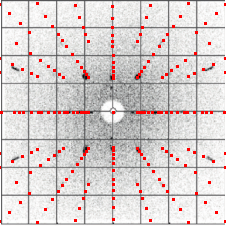

In [3]:
#
# Example use of the above functions for HoFeO3 from the literature.
# M. Shao, et al. J. Cryst. Growth 318, 947-50 (2011)
#
from PIL import Image
import ase.io
HoFeO3Laue = Image.open("HoFeO3.PNG")
hfo = ase.io.read("HoFeO3.cif")
# Align the incident beam perpindicular to the
# b axis as proposed
UB = np.array([[0,1,0],[1,0,0],[0,0,1]])
spots = calcLaue(HoFeO3Laue.size,hfo.get_cell_lengths_and_angles(),dd=32,UB=UB,betgam=(0,90))
overlayLaue(HoFeO3Laue,spots)

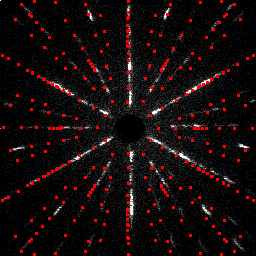

In [4]:
#
# Example use of the above functions for Nb3Br8 as provided
# in issue #9. In this case, the raw Laue image is a flat
# file containing 256x256 16-bit unsigned ints in big
# endian format, and the crystal has c oriented along the 
# beam source axis, instead of a.
#
from PIL import Image
import ase.io
# Read 16-bit Laue image
with open("Nb3Br8.hs2","r") as f:
    Nb3Br8Laue = np.array(np.fromfile(f,dtype='>u2',count=256*256,sep='').reshape((256,256)),dtype=np.uint16)
Nb3Br8Laue = Image.fromarray(Nb3Br8Laue/20).convert("RGB")
Nb3Br8 = ase.io.read("Nb3Br8.cif")
# Orient c along incident beam
UB=np.array([[0,0,1],[0,1,0],[1,0,0]])
spots = calcLaue(Nb3Br8Laue.size,Nb3Br8.get_cell_lengths_and_angles(),dd=12,UB=UB,betgam=(0,60),Ecut=(5,10))
overlayLaue(Nb3Br8Laue,spots)

Missing fabio module. Please install it if you need open some tiff images from the sCMOS camera
Missing library libtiff, Please install: pylibtiff if you need open some tiff images
module Image / PIL is not installed
Cython compiled module 'gaussian2D' for fast computation is not installed!
module Image / PIL is not installed
Using 'Data_for_localMaxima' ndarray for finding local maxima
Data.shape for local maxima (226, 226)
Using simple intensity thresholding to detect local maxima (method 1/3)
len(peaklist) 22
Local maxima search. Execution time : 0.009 seconds
Keep 22 from 22 initial peaks (ready for peak positions and shape fitting)


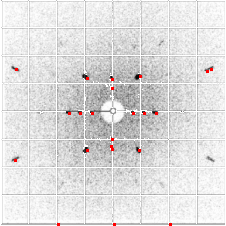

In [5]:
#
# Example use of LaueTools to do automatic peak finding/extraction
# from an 8-bit, RGB png input datafile
#
from PIL import Image
import LaueTools.readmccd as rmccd
# Convert to grayscale on load
pic = Image.open("HoFeO3-PP.PNG").convert('L')
# Invert image so bright points are spots
nppic = np.array(pic)
nppic = np.full(nppic.shape,255,dtype=np.uint8) - nppic
nppic = np.array(nppic,dtype=np.uint16)*256
# Do peak search
rv = rmccd.PeakSearch("",Data_for_localMaxima=nppic,fit_peaks_gaussian=0,PixelNearRadius=2,local_maxima_search_method=0,IntensityThreshold=0.7*np.amax(nppic))
overlayLaue(pic.convert("RGB"),np.vstack((rv[0][:,0],rv[0][:,0],rv[0][:,0],rv[0][:,0],rv[0][:,1])))

Using 'Data_for_localMaxima' ndarray for finding local maxima
Data.shape for local maxima (256, 256)
Using simple intensity thresholding to detect local maxima (method 1/3)
len(peaklist) 70
Local maxima search. Execution time : 0.009 seconds
Keep 66 from 70 initial peaks (ready for peak positions and shape fitting)


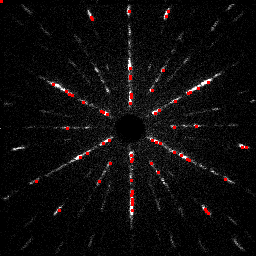

In [6]:
#
# Example use of LaueTools to do automatic peak finding/extraction
# from a 16-bit, measured counts input datafile
#
from PIL import Image
import LaueTools.readmccd as rmccd
# Read 16-bit Laue image
with open("Nb3Br8.hs2","r") as f:
    nppic = np.array(np.fromfile(f,dtype='>u2',count=256*256,sep='').reshape((256,256)),dtype=np.uint16)
# Do peak search
rv = rmccd.PeakSearch("",Data_for_localMaxima=nppic,fit_peaks_gaussian=0,PixelNearRadius=2,local_maxima_search_method=0,IntensityThreshold=0.15*np.amax(nppic))
overlayLaue(Image.fromarray(nppic/20).convert("RGB"),np.vstack((rv[0][:,0],rv[0][:,0],rv[0][:,0],rv[0][:,0],rv[0][:,1])))